# transforms

> 2D Matrix transformations to manipulate a series of `(x,y)` coordinates.

In [ ]:
#| default_exp transforms

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Arc

In [ ]:
# |export
from dataclasses import dataclass

import numpy as np

## 2D Affine Transformations

For manipulating sets of stroke-3 coordinates, I often needed to transform the coordinates - rescaling, rotating, moving, etc.

2D affine transformations are perfect for this. Each transformation is expressed as a matrix, and is applied by performing matrix multiplication against the 2D matrix of coordinates (with a column of `1` values concatenated next to `x` and `y` values).


In [ ]:
#| exports
def apply_transform(coords_2d, xform):
    assert coords_2d.shape[1] == 2
    assert xform.shape[0] == 3
    assert xform.shape[1] == 3

    coords_full = np.concatenate([coords_2d, np.ones((coords_2d.shape[0], 1))], axis=1)
    assert coords_full.shape[0] == coords_2d.shape[0]
    assert coords_full.shape[1] == 3

    return xform.dot(coords_full.transpose()).transpose()[:,:2]

Consider a sample set of x,y coordinates:

|x|y|
|-|-|
|0|0|
|0.5|0.5|
|1|1|

The simplest affine transformation is the identity.

Multiplying the 2D coords by the following matrix will output an identical set of coordinates:
```
1   0   0
0   1   0
0   0   1
```

In [ ]:
#| exports
def identity_xform():
    return np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]])

In [ ]:
sample_coords = np.array([
    [0.0,0.0],
    [0.5,0.5],
    [1.0,1.0],
])

test(apply_transform(sample_coords, identity_xform()),
     sample_coords,
     np.array_equal)

Scaling a set of coordinates by `sx` in the `x` direction and `sy` in the `y` direction is as easy as multiplying by:
```
sx  0   0
0   sy  0
0   0   1
```

In [ ]:
#| exports
def scale_xform(sx, sy):
    return np.array([
        [sx, 0, 0],
        [0, sy, 0],
        [0, 0, 1]])

In [ ]:
scaled_coords_2x_3y = np.array([
    [0.0,0.0],
    [1.0,1.5],
    [2.0,3.0],
])

test(apply_transform(sample_coords, scale_xform(sx=2.0, sy=3.0)),
     scaled_coords_2x_3y,
     np.array_equal)

Translating a set of coordinates by `tx` in the `x` direction and `ty` in the `y` direction uses the following matrix.
```
1   0   tx
0   1   ty
0   0   1
```

In [ ]:
#| exports
def translate_xform(tx, ty):
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]])

In [ ]:
translated_coords_2x_3y = np.array([
    [2.0,3.0],
    [2.5,3.5],
    [3.0,4.0],
])

test(apply_transform(sample_coords, translate_xform(tx=2.0, ty=3.0)),
     translated_coords_2x_3y,
     np.array_equal)

In [ ]:
#| hide
def get_angle_plot(line1, line2, offset = 1, color = None, origin = [0,0], len_x_axis = 1, len_y_axis = 1):
    l1xy = line1.get_xydata()

    # Angle between line1 and x-axis
    slope1 = (l1xy[1][1] - l1xy[0][1]) / float(l1xy[1][0] - l1xy[0][0])
    angle1 = abs(math.degrees(math.atan(slope1))) # Taking only the positive angle

    l2xy = line2.get_xydata()

    # Angle between line2 and x-axis
    slope2 = (l2xy[1][1] - l2xy[0][1]) / float(l2xy[1][0] - l2xy[0][0])
    angle2 = abs(math.degrees(math.atan(slope2)))

    theta1 = min(angle1, angle2)
    theta2 = max(angle1, angle2)

    angle = theta2 - theta1

    if color is None:
        color = line1.get_color() # Uses the color of line 1 if color parameter is not passed.

    return Arc(origin,
               width=len_x_axis*offset,
               height=len_y_axis*offset,
               angle=0,
               theta1=theta1,
               theta2=theta2,
               color=color,
               label=str(angle)+u"\u00b0")

def get_angle_text(angle_plot, label=None):
    angle = angle_plot.get_label()[:-1] # Excluding the degree symbol
    angle = "%0.1f"%float(angle)+u"\u00b0" # Display angle up to 1 decimal place

    # Get the vertices of the angle arc
    vertices = angle_plot.get_verts()

    # Get the midpoint of the arc extremes
    x_width = (vertices[0][0] + vertices[-1][0]) / 2.0
    y_width = (vertices[0][-1] + vertices[-1][-2]) / 2.0

    separation_radius = max(x_width/2.0, y_width/2.0)

    return [ x_width + separation_radius, y_width + separation_radius, angle if not label else f"{label}: {angle}"]       

To rotate a set of 2D coordinates by `n` degrees, we first convert the desired angle of rotation from degrees to a value in radians, `theta`.

Consider a point `(x1, y1)` at `(4, 4)` that I want to rotate by 30 degrees around the origin. If I make a line to the origin with length `r`, the angle between line1 and the x axis, which I'll call `phi`, is 45 degrees.

```python
x1 = r * cos(phi) = 4
y1 = r * sin(phi) = 4
```

If I want to rotate it by 30 degrees, its final position at point `(x2, y2)` will be 45 + 30 = 75 degrees from the x-axis, equivalent to `phi + theta`.

```python
x2 = r * cos(phi + theta)
y2 = r * sin(phi + theta)
```

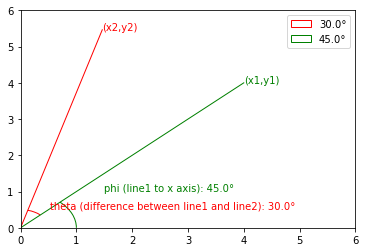

In [ ]:
#| echo: false

fig = plt.figure()

line_1 = Line2D([0,4], [0,4], linewidth=1, linestyle = "-", color="green")


line2_radians = np.radians(75)
line1_length = np.sqrt(4*4 + 4*4)
x2 = np.cos(line2_radians)*line1_length
y2 = np.sin(line2_radians)*line1_length
line_2 = Line2D([0,x2], [0,y2], linewidth=1, linestyle = "-", color="red")

ax = fig.add_subplot(1,1,1)

ax.add_line(line_1)
ax.add_line(line_2)

angle_plot = get_angle_plot(line_1, line_2, 1, color="red")
angle_text = get_angle_text(angle_plot, label="theta (difference between line1 and line2)") 
# Gets the arguments to be passed to ax.text as a list to display the angle value besides the arc

ax.add_patch(angle_plot) # To display the angle arc
ax.text(*angle_text, color="red") # To display the angle value


line_xaxis = Line2D([0,2], [0,0], linewidth=1, linestyle = "-", color="black")
ax.add_line(line_xaxis)
angle_plot = get_angle_plot(line_1, line_xaxis, 2, color="green") # Second angle arc will be red in color
angle_text = get_angle_text(angle_plot, label="phi (line1 to x axis)")
ax.add_patch(angle_plot) # To display the 2nd angle arc
ax.text(*angle_text, color="green") # To display the 2nd angle value

ax.annotate("(x1,y1)", (4,4), color="green")
ax.annotate("(x2,y2)", (x2,y2), color="red")

ax.set_xlim(0,6)
ax.set_ylim(0,6)

plt.legend()
plt.show()

Since `cos(a + b) = cos(a)*cos(b) - sin(a)*sin(b)` and `sin(a + b) = sin(a)*cos(b) + cos(a)*sin(b)`, this breaks down into:

```python
x2 = r * cos(phi + theta)
   = r * cos(phi) * cos(theta) - r * sin(phi) * sin(theta)
   = x1 * cos(theta) - y1 * sin(theta)

y2 = r * sin(phi + theta)
   = r * sin(phi) * cos(theta) + r * cos(phi) * sin(theta)
   = y1 * cos(theta) + x1 * sin(theta)
```

So, multiplying any 2D coordinates by the following matrix will produce the correct rotation:
```
cos(theta)   -sin(theta)  0
sin(theta)   cos(theta)   0
0            0            1
```

In [ ]:
#| exports
def rotate_xform(rotate_angle):
    if rotate_angle % 360 == 0:
        return identity_xform()
    theta = np.radians(rotate_angle)
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)
    return np.array([
        [cos_theta, -sin_theta, 0],
        [sin_theta, cos_theta, 0],
        [0, 0, 1]
    ])

## Bounding Boxes

In [ ]:
#| exports
class BoundingBox:
    xmin: float
    xmax: float
    ymin: float
    ymax: float
    xrange: float
    yrange: float

    def __init__(self, xmin, xmax, ymin, ymax):
        assert xmin <= xmax
        assert ymin <= ymax
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.xrange = xmax - xmin
        self.yrange = ymax - ymin

    def __repr__(self):
        return f"BBox(({self.xmin}, {self.ymin}), ({self.xmax}, {self.ymax})) (width {self.xrange} x height {self.yrange})"

    @staticmethod
    def create(coords: np.ndarray):
        # rank-2
        if len(coords.shape) == 2:
            xmin = coords[:, 0].min()
            xmax = coords[:, 0].max()

            ymin = coords[:, 1].min()
            ymax = coords[:, 1].max()

            return BoundingBox(
                xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax
            )
        else:
            raise Exception(f"invalid coordinates passed - expected rank-2 matrix but got rank-{len(coords.shape)}")

    def merge(self, other):
        return BoundingBox(
            xmin=min(self.xmin, other.xmin),
            xmax=max(self.xmax, other.xmax),
            ymin=min(self.ymin, other.ymin),
            ymax=max(self.ymax, other.ymax),
        )

    def area(self):
        return self.xrange * self.yrange

    def intersection(self, other):
        bb1 = self
        bb2 = other

        assert bb1.xmin <= bb1.xmax
        assert bb1.ymin <= bb1.ymax
        assert bb2.xmin <= bb2.xmax
        assert bb2.ymin <= bb2.ymax

        x_left = max(bb1.xmin, bb2.xmin)
        y_top = max(bb1.ymin, bb2.ymin)
        x_right = min(bb1.xmax, bb2.xmax)
        y_bottom = min(bb1.ymax, bb2.ymax)

        if x_right < x_left or y_bottom < y_top:
            return None
        
        return BoundingBox(xmin=x_left, ymin=y_top, xmax=x_right, ymax=y_bottom)

    def iou(self, other):
        """
        Intersection over union - area of the overlap relative to combined area of the bounding boxes
        """
        overlap = self.intersection(other)
        if not overlap:
            return 0.0
        return overlap.area() / float(self.area() + other.area() - overlap.area())
        
    def normalization_xform(self, scale=1.0):
        """
        Produce a normalization transform - a set of transformations,
        given the input coordinates, to convert all coords into the range (0,1)
        """
        max_range = self.xrange if self.xrange > self.yrange else self.yrange
        return scale_xform(scale / max_range, scale / max_range).dot(
            translate_xform(-self.xmin, -self.ymin)
        )

In [ ]:
show_doc(BoundingBox.create)

---

### BoundingBox.create

>      BoundingBox.create (coords:numpy.ndarray)

In [ ]:
show_doc(BoundingBox.merge)

---

### BoundingBox.merge

>      BoundingBox.merge (other)

In [ ]:
show_doc(BoundingBox.area)

---

### BoundingBox.area

>      BoundingBox.area ()

In [ ]:
show_doc(BoundingBox.intersection)

---

### BoundingBox.intersection

>      BoundingBox.intersection (other)

In [ ]:
show_doc(BoundingBox.iou)

---

### BoundingBox.iou

>      BoundingBox.iou (other)

Intersection over union - area of the overlap relative to combined area of the bounding boxes

In [ ]:
show_doc(BoundingBox.normalization_xform)

---

### BoundingBox.normalization_xform

>      BoundingBox.normalization_xform (scale=1.0)

Produce a normalization transform - a set of transformations,
given the input coordinates, to convert all coords into the range (0,1)

## Stroke-3 Conversion

In [ ]:
#| export
def strokes_to_points(strokes):
    all = []
    for s in strokes:
        eoc_col = np.zeros((s.shape[0], 1))
        eoc_col[-1, 0] = 1
        all.append(np.concatenate([s[:, :2], eoc_col], axis=1))
    return np.vstack(all)


def points_to_deltas(points):
    p2 = points.copy()
    # first row should stay the same
    # cols 0,1 of every row onwards should be a delta from the previous row.
    p2[1:, :2] = points[1:, :2] - points[:-1, :2]
    return p2


def strokes_to_deltas(strokes):
    points = strokes_to_points(strokes)
    return points_to_deltas(points)

In [ ]:
#| export
def deltas_to_points(_seq):
    seq = np.zeros_like(_seq)
    seq[:, 0:2] = np.cumsum(_seq[:, 0:2], axis=0)
    seq[:, 2] = _seq[:, 2]
    return seq


def points_to_strokes(_seq):
    strokes = np.split(_seq, np.where(_seq[:, 2] > 0)[0] + 1)
    return [
        s for s in strokes if len(s) > 0
    ]  # split sometimes returns an empty array at the end


def deltas_to_strokes(_seq):
    points = deltas_to_points(_seq)
    return points_to_strokes(points)

## RDP

In [ ]:
#| export
from rdp import rdp


def rdp_strokes(strokes, epsilon=1.0):
    return [rdp(s, epsilon=epsilon) for s in strokes]

In [ ]:
#| export
def stroke_rdp_deltas(rescaled_strokes, epsilon=2.0):
    rdp_result = rdp_strokes(rescaled_strokes, epsilon)
    deltas = strokes_to_deltas(rdp_result)

    ## roundtrip / sanity check
    # _rdp_result = stroke3.deltas_to_strokes(deltas)
    # default.plot_strokes(_rdp_result)

    return deltas

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()